# Assignment 2

Author: Danis Alukaev \
Email:  d.alukaev@innopolis.university \
Group:  B19-DS-01

## Prerequisites

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import torch
import os
import cv2
from random import randint

from operator import itemgetter
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from skimage import io
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import SGD, Adam, Adamax, RMSprop
from torch.nn import MSELoss, L1Loss, functional as F, Conv2d, ConvTranspose2d, Upsample, Module, BatchNorm2d


## 3. Practical Tasks on Ensemble learning 

### Step 1. Read and split the dataset. 

The used dataset was assembled to train systems solving the problem of malware detection on Android system. This dataset is distributed in the `csv` format and includes information about the network traffic (used ports, number of packets, quantity of bytes). The target variable is called `type` and takes two values: `malicious` and `benign`. The dataset was placed in directory `/datasets/Practical Task 1`. 

In [2]:
df1 = pd.read_csv('./datasets/Practical Task 1/android_traffic.csv')

Since the target variable is string and takes only two values, it makes sense to encode this attribute using `LabelEncoder`. Having mixture of numbers and chars in one architecture considered to be a bad practice.

In [3]:
target = df1['type']

le = LabelEncoder()
le.fit(target)
classes = le.classes_

target_encoded = le.transform(target)
target_encoded = pd.DataFrame(target_encoded, columns=['type'], dtype=int)

features = df1[df1.columns.drop('type')]
df1_encoded = pd.concat([features, target_encoded], axis=1)

Split the data into the train and test sets of 80% and 20% respectively using `train_test_split`.

In [4]:
features_encoded = df1_encoded[df1_encoded.columns.drop('type')]
target_encoded = df1_encoded['type']

x_train, x_test, y_train, y_test = train_test_split(features_encoded, target_encoded, test_size=0.2, random_state=42)

In [5]:
print(f"The overall number of records is {len(df1_encoded)}.")
print(f"The initial dataset was splitted into two parts of {len(x_train)} and {len(x_test)} records corresponding to {len(x_train) / len(df1_encoded) * 100}% and {len(x_test) / len(df1_encoded) * 100}% respectively.")

The overall number of records is 7845.
The initial dataset was splitted into two parts of 6276 and 1569 records corresponding to 80.0% and 20.0% respectively.


### Step 2. Create models.

To solve malware classification problem there will be used three ensemble models with base classifier `Decision Tree`:
- **Random Forest** that fits decision trees on various subsets of the dataset and uses averaging to improve the predictive accuracy
- **Bagging Classifier** (extension of Random Forest idea) that fits base classifiers on random subsets of the dataset and the aggregates obtained individual predictions 
- **Ada Boost Classifier** that fits base classifier on the dataset and then fits copies of this classifier on the same dataset adjusting weights for difficult cases 

In [6]:
random_forest = RandomForestClassifier(max_depth=15)
bagging_classifier = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15))
ada_boost_classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=15))

### Step 3. Fine-tune some hyperparameters.

For hyperparameters optimization there will be used Grid Search approach. \
Now we are focusing on the following parameters*:
- `n_estimators` with the range `[30..70]`  
- `max_features` (for base estimators) with possibles values `log2` and `sqrt`
- `min_impurity_decrease` (for base estimators) with range `np.logspace(-6, -9, num=13)`

\* ranges were taken directly from the [QA list](https://docs.google.com/spreadsheets/d/1wK8v95tFyHC07NBwODW4ejKOXUsTYTCjtk2kReUUKiM/edit#gid=0) 

In [7]:
def fine_tune_params(estimators, parameters, x, y, print_params=False):
    """
    Method performing exhaustive search over specified parameter settings for a given estimator.

    :param estimator: examined estimator
    :param parameters: parameter settings
    :param x: set of features
    :param y: set of target variables 
    :param print_params: flag to explicitly print best settings
    :return: parameter settings that gave best result
    """
    results = []
    for estimator, params in zip(estimators, parameters):
        name = estimator.__class__.__name__
        print(f"Grid Searching for {name} estimator...")
        grid_searcher = GridSearchCV(estimator, params)
        grid_searcher.fit(x, y)

        if print_params:
            print("Best settings:")
            best_params = grid_searcher.best_params_
            keys = best_params.keys()
            offset = len(max(keys, key=len)) + 5
            for param, value in best_params.items():
                print(f"- {param.ljust(offset)}: {value}")
        print(f"Best parameters setting yields mean cross-validated score {grid_searcher.best_score_}.\n")
        results.append((name, grid_searcher))
    return results

In [8]:
def get_param_space(mask):
    """
    Method creating parameter space for grid search on ensemble models.
    Focuses on parameters n_estimators, max_features, min_impurity_decrease.

    :param mask: list of bool indicating whether max_features, min_impurity_decrease should be tuned for base estimators
    :return: parameter space
    """
    param_space = []
    for use_base_estimator in mask:
        keys = ['n_estimators', 'max_features', 'min_impurity_decrease']
        values = [np.arange(30, 80, 10), ['sqrt', 'log2'], np.logspace(-6, -9, num=13)]
        if use_base_estimator:
            keys[1], keys[2] = 'base_estimator__max_features', 'base_estimator__min_impurity_decrease'
        params = dict(zip(keys, values))
        param_space.append(params)
    return param_space

mask = [False, True, True]
param_space = get_param_space(mask)

Using the defined method `fine_tune_params` let's perform a grid search for recently created estimators `random_forest`, `bagging_classifier`, and `ada_boost_classifier`. \
Note for hyperparameter tuning there was used train dataset. It is usually recommended not to use test dataset during the parameters search or model selection, because the obtained model is prone to overfitting.    

In [9]:
estimators = [random_forest, bagging_classifier, ada_boost_classifier]
results_step3 = fine_tune_params(estimators, param_space, x_train, y_train, print_params=True)

Grid Searching for RandomForestClassifier estimator...
Best settings:
- max_features              : sqrt
- min_impurity_decrease     : 5.623413251903491e-09
- n_estimators              : 70
Best parameters setting yields mean cross-validated score 0.8891005405131068.

Grid Searching for BaggingClassifier estimator...
Best settings:
- base_estimator__max_features              : log2
- base_estimator__min_impurity_decrease     : 3.162277660168379e-07
- n_estimators                              : 50
Best parameters setting yields mean cross-validated score 0.8884625827898596.

Grid Searching for AdaBoostClassifier estimator...
Best settings:
- base_estimator__max_features              : log2
- base_estimator__min_impurity_decrease     : 3.162277660168379e-08
- n_estimators                              : 40
Best parameters setting yields mean cross-validated score 0.8715725632501841.



Based on the obtained results now we can create final estimators, fit them, and evaluate on the test set. The evaluation will be performed using accuracy classification score.

In [10]:
def create_models(mask, results, estimators, max_depth=15, BaseEstimator=DecisionTreeClassifier):
    """ 
    Method creating final models using th best values of hyperparameters. 

    :param mask: list of bool indicating whether max_features, min_impurity_decrease should be tuned for base estimators
    :param results: results of fine-tuning from fine_tune_params
    :param estimators: dictionary with estimator name as key and estimator as value 
    :param max_depth: maximal depth of the tree
    :param BaseEstimator: sklearn estimator used as base estimator, e.g. in BaggingClassifier, AdaBoostClassifier
    :return: initialized estimators
    """
    initialized = []
    for result, use_base_estimator in zip(results, mask):
        name, grid_searcher = result
        Estimator = estimators[name]
        best_params = grid_searcher.best_params_
        estimator_config = {'n_estimators': best_params['n_estimators']} 
        if not use_base_estimator:
            estimator_config['max_depth'] = max_depth
            estimator_config['max_features'] = best_params['max_features']
            estimator_config['min_impurity_decrease'] = best_params['min_impurity_decrease']
        else:
            base_estimator_config = {
                'max_depth': max_depth, 
                'max_features': best_params['base_estimator__max_features'], 
                'min_impurity_decrease': best_params['base_estimator__min_impurity_decrease']
            }
            base_estimator = BaseEstimator(**base_estimator_config)
            estimator_config['n_estimators'] = best_params['n_estimators']
            estimator_config['base_estimator'] = base_estimator
        estimator = Estimator(**estimator_config)
        entry = (name, estimator)
        initialized.append(entry)
    return initialized

In [11]:
def test_models(initialized, x_train, y_train, x_test, y_test, max_depth=15, BaseEstimator=DecisionTreeClassifier, class_report=False):
    """ 
    Method evaluating them on the test set. 

    :param initialized: initialized sklearn estimators
    :param x_train: traing attributes
    :param y_train: train target variable
    :param x_test: test attributes
    :param y_test: test target variable
    :param max_depth: maximal depth of the tree
    :param BaseEstimator: sklearn estimator used as base estimator, e.g. in BaggingClassifier, AdaBoostClassifier
    :param class_report: flag indicating whether the classification report should be displayed
    :return: fitted estimators
    """
    trained_models = []
    for name, estimator in initialized:
        estimator.fit(x_train, y_train)
        trained_models.append(estimator)
        
        prediction = estimator.predict(x_test)
        accuracy = accuracy_score(y_test, prediction)
        print(f"Accuracy score for estimator {name} is {accuracy}.")
        if class_report:
            print(f"Classification report for {name}:")
            print(classification_report(y_test, prediction))
    return trained_models

In [12]:
estimators = {
    'RandomForestClassifier': RandomForestClassifier,
    'BaggingClassifier': BaggingClassifier,
    'AdaBoostClassifier': AdaBoostClassifier
}
mask = [False, True, True]

initialized = create_models(mask, results_step3, estimators)
trained_models = test_models(initialized, x_train, y_train, x_test, y_test, class_report=True)

Accuracy score for estimator RandomForestClassifier is 0.8948374760994264.
Classification report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       938
           1       0.89      0.85      0.87       631

    accuracy                           0.89      1569
   macro avg       0.89      0.89      0.89      1569
weighted avg       0.89      0.89      0.89      1569

Accuracy score for estimator BaggingClassifier is 0.9037603569152326.
Classification report for BaggingClassifier:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       938
           1       0.90      0.85      0.88       631

    accuracy                           0.90      1569
   macro avg       0.90      0.90      0.90      1569
weighted avg       0.90      0.90      0.90      1569

Accuracy score for estimator AdaBoostClassifier is 0.8776290630975143.
Classification report for AdaBoostC

**Question:** 

Which model performed the best on the test set? Why do you think that is the case?

**Discussion:** 

The best performance was shown by the bagging classifier with approximate accuracy score of `0.904`, it is followed by the random forest with the score of `0.895`, and ada boosting proved to be the worst with the score of `0.878`. The results for bagging classifier and random forest seem to be compatible, but the results of boosting differ significantly. The reason may be the base estimator: boosting is usually used where the model is stable and has a high bias. In our case, the decision tree is a model that is very dependent on input data and prone to overfit. Therefore, the use of boosting is not justified here. 

### Step 4. Theoretical question on maximal depth.
**Question:** 

If you fine-tuned the hyper-parameter `max_depth` as well, which of the three ensemble models would you expect to have deeper (larger `max_depth` value) base learners and which would have shallower base learners? Why do you think that would be the case?

**Discussion:** 

My assumption is that random forest and bagging classifiers tend to have deeper base learners whereas the adaboosting - shallower. The decision trees are prone to overfit, i.e. they typically have a large variance due to the greedy nature. Random forest and its extension bagging reduce the variance (e.g. by averaging), so that we are not concerned with overfitting of individual trees. As a result, they grow deeper and not prune. On the contrary, the decision trees involved in adaboosting focuses only on elimination of weaknesses of the previous estimator. Such an approach leads to higher bias and lower depth of base estimators.

### Step 5: Yet another tuning of hyperparameters.

Initialize the models with the best parameters from the third step.

In [13]:
initialized = [model for _, model in create_models(mask, results_step3, estimators)]

Fine tune the parameter `max_depth` from `5` to `25`.

In [14]:
param_space = [
    {'max_depth': np.arange(5, 26, 1)}, 
    {'base_estimator__max_depth': np.arange(5, 26, 1)}, 
    {'base_estimator__max_depth': np.arange(5, 26, 1)}
]
estimators = {
    'RandomForestClassifier': RandomForestClassifier,
    'BaggingClassifier': BaggingClassifier,
    'AdaBoostClassifier': AdaBoostClassifier
}
mask = [False, True, True]

results_step5 = fine_tune_params(initialized, param_space, x_train, y_train, print_params=True)

Grid Searching for RandomForestClassifier estimator...
Best settings:
- max_depth     : 23
Best parameters setting yields mean cross-validated score 0.893721420052275.

Grid Searching for BaggingClassifier estimator...
Best settings:
- base_estimator__max_depth     : 24
Best parameters setting yields mean cross-validated score 0.8946777222320907.

Grid Searching for AdaBoostClassifier estimator...
Best settings:
- base_estimator__max_depth     : 7
Best parameters setting yields mean cross-validated score 0.8717335752531277.



Let's plot dependence of cross validation accuracy of initialized ensemble models from `max_depth` parameter. The cross validation results stored as a dictionary in attribute `cv_results_` of the `GridSearch` instance. By default it uses 5-fold cross validation. We will use mean test score to plot the graph.

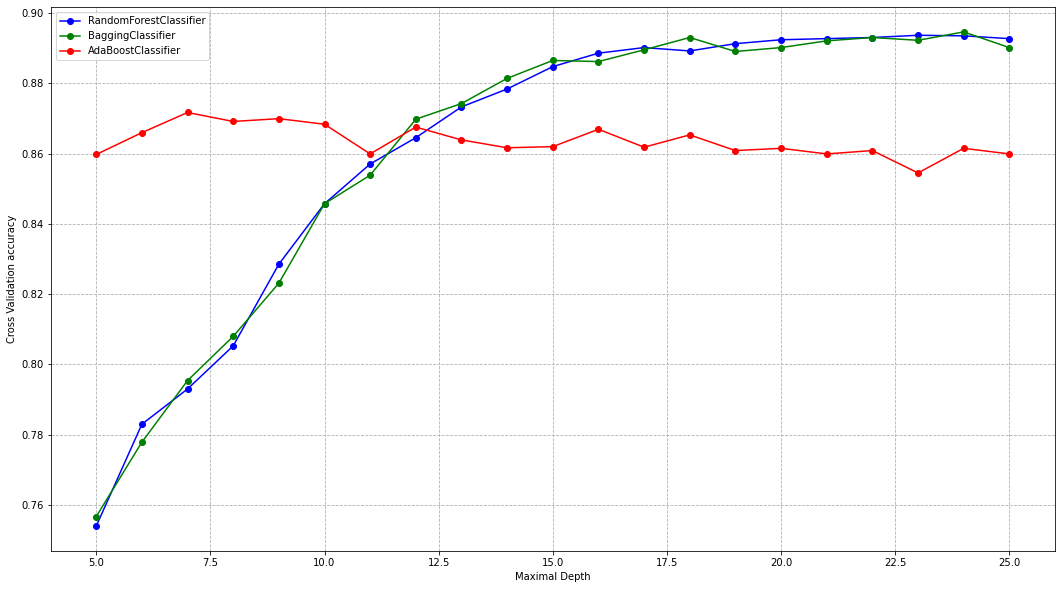

In [15]:
def plot_score(score):
    """
    Method plotting Mean Cross Validation test score for Random Forest, 
    Bagging, and Ada Boosting classifiers.
    
    :param score: numpy array of size (3, number of max depth params).
    """
    random_forest_name, random_forest_score = score[0]
    bagging_classifier_name, bagging_classifier_score = score[1]
    ada_boosting_name, ada_boosting_score = score[2]

    depths = np.arange(5, 26, 1)

    fig = plt.figure(figsize=(18,10))
    ax = fig.add_subplot(111)
    ax.grid(linestyle='--')
    ax.set_xlabel('Maximal Depth')
    ax.set_ylabel('Cross Validation accuracy')
    ax.plot(depths, random_forest_score, '-o', c='b', label=random_forest_name)
    ax.plot(depths, bagging_classifier_score, '-o', c='g', label=bagging_classifier_name)
    ax.plot(depths, ada_boosting_score, '-o', c='r', label=ada_boosting_name)   
    ax.legend() 
    plt.show()

test_score = [(name, grid_searcher.cv_results_['mean_test_score']) for name, grid_searcher in results_step5]
plot_score(test_score)

**Question:** 

Do the results agree with your answer in the previous part?

**Discussion:** 

As you can see, adaboosting achieves the greatest accuracy at a shallow depth over the entire depth range relative to the results of random forest and bagging classifier. My answer in the last section pretty much reflects the empirical results.

## 4. Practical Tasks on CNN

**Important note:**

For this task I decided to use PyTorch framework. Compared to Keras, it provides lower-level capabilities for building architectures, better debugging, and greater speed. Based on the [gi4e dataset](https://www.unavarra.es/gi4e/databases/gi4e/) there was created custom dataset and dataloader objects. Such an approach tends to be more efficient in terms of memory than keeping lists of images. Further, I have built a CNN model called IrisCA based on architecture proposed in [paper](https://ieeexplore.ieee.org/abstract/document/8803121). This is the fully convolutional network which consists of a base network and auxiliary network. The name of this architecture consists of the scope of application - segmentation of the iris (pupil) and similarity with the inclined letter C (C-like Architecture).

### Step 1. Preprocess and visualize the dataset.

All the preprocessing steps are implemented inside the IrisDataset class. For the sake of memory saving images are processed on demand, i.e. once the item getter is called. However, let's explore raw data. Images along with annotations were placed in directory `/datasets/Practical Task 2`.

In [16]:
def visualize_image(root_dir, image_name):
    """
    Method used to visualize image with annotations.

    :param root_dir: directory with gi4e dataset
    :param image_name: name of image to be displayed
    """
    image_dir = os.path.join(root_dir, 'images')
    labels_dir = os.path.join(root_dir, 'labels')
    
    image_path = os.path.join(image_dir, image_name)
    label_path = os.path.join(labels_dir, f"{image_name[:3]}_image_labels.txt")

    image = io.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    attributes = [
        'Image', 
        'L-L-x', 'L-L-y', 'L-M-x', 'L-M-y', 'L-R-x', 'L-R-y', 
        'R-L-x', 'R-L-y', 'R-M-x', 'R-M-y', 'R-R-x', 'R-R-y'
    ]
    annotation = pd.read_csv(label_path, sep='\t', names=attributes)
    annotation = annotation[annotation['Image'] == image_name].squeeze()

    fig = plt.figure(figsize=(18,10))
    ax = fig.add_subplot(111)
    ax.imshow(image, cmap='gray')
    ax.scatter(
        annotation[['L-L-x', 'R-L-x', 'L-M-x', 'R-M-x', 'L-R-x', 'R-R-x']], 
        annotation[['L-L-y', 'R-L-y', 'L-M-y', 'R-M-y', 'L-R-y', 'R-R-y']], 
        c='r', s=5
    )
    plt.axis('off')
    plt.show()

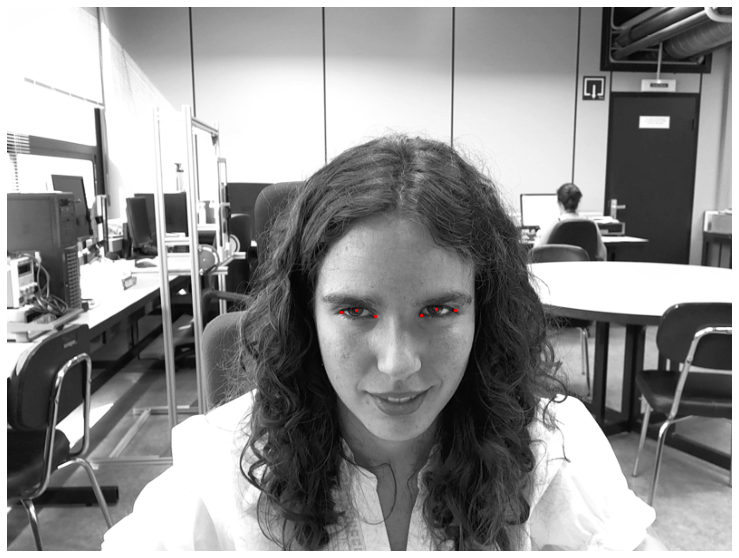

In [17]:
root_dir = './datasets/Practical Task 2'
image_name = '001_04.png'
visualize_image(root_dir, image_name)

In [18]:
class IrisDataset(Dataset):
    """
    Custom PyTorch dataset used for better readability and modularity of gi4e dataset.
    Implements len method and item getter. Eyes are accessed separately, e.g. for image 001_01.png
    dataset[0] will return the left eye on the image, and dataset[1] - the right. 
    ! Subtask n from the first step of Task 4 should be marked (n) in inline comments of __get_item__.
    The target segmentation masks were created as it recommended in the paper: instead of 1 pixels there was
    place 3x3 square and Gaussian Blur applied.
    """

    def __init__(self, root_dir, image_size=48, padding=0.4):
        self.image_size = image_size
        self.padding = padding
        self.storage_dir = os.path.join(root_dir, 'images')
        self.annotation_dir = os.path.join(root_dir, 'labels')
        self.columns = {
            'all': ['Image', 'L-L-x', 'L-L-y', 'L-M-x', 'L-M-y', 'L-R-x', 'L-R-y', 
                    'R-L-x', 'R-L-y', 'R-M-x', 'R-M-y', 'R-R-x', 'R-R-y'], 
            'left': ['Image', 'L-L-x', 'L-L-y', 'L-M-x', 'L-M-y', 'L-R-x', 'L-R-y'],   
            'right': ['Image', 'R-L-x', 'R-L-y', 'R-M-x', 'R-M-y', 'R-R-x', 'R-R-y'],
            'default': ['Image', 'L-x', 'L-y', 'M-x', 'M-y', 'R-x', 'R-y']
        }

    def __len__(self):
        counter = 0
        for file in os.listdir(self.storage_dir):
            if file.endswith('.png'):
                counter += 1
        return 2 * counter

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # implement the mapping from indexes to filenames
        case_idx = idx // 2 
        label = 'left' if idx % 2 == 0 else 'right'

        series_idx = case_idx // 12 + 1
        image_idx = case_idx % 12 + 1

        image_name = f'{series_idx:03d}_{image_idx:02d}.png'
        annotation_name = f'{series_idx:03d}_image_labels.txt'

        image_path = os.path.join(self.storage_dir, image_name)        
        annotation_path = os.path.join(self.annotation_dir, annotation_name)

        # (2) read image and convert it to grayscale
        image = io.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # (5) normalize the image
        image = image / 255.0

        # (3) read annotation for image
        annotation = pd.read_csv(annotation_path, sep='\t', names=self.columns['all'])
        annotation = annotation[annotation['Image'] == f'{series_idx:03d}_{image_idx:02d}.png'].squeeze()  

        landmarks = annotation[self.columns[label]]
        landmarks.index = self.columns['default']
        
        # (6.1) crop eye regions (using coordinates of eye corners)
        l_x, l_y, _, _, r_x, r_y = landmarks[self.columns['default'][1:]]
        center_y = (r_y + l_y) // 2
        eye_width = abs(r_x - l_x)
        padding = eye_width * self.padding
        l_x, r_x = sorted([l_x, r_x])
        x_min, x_max = map(int, [l_x - padding // 2, r_x + padding // 2])
        y_min, y_max = sorted(map(int, [center_y - (eye_width + padding) // 2, center_y + (eye_width + padding) // 2]))
        new_width = eye_width + padding
        roi = image[y_min:y_max, x_min:x_max]
        # (6.2) resize to 48x48
        roi = cv2.resize(roi, 2*[self.image_size], interpolation=cv2.INTER_AREA)
        
        # (7.1) convert iris center (and corners)        
        def new_coordinate(x, original_size, new_size):
            return x/(original_size/new_size)

        landmarks_resized = {
            'L-x': new_coordinate(landmarks['L-x']-x_min, new_width, self.image_size), 'L-y': new_coordinate(landmarks['L-y']-y_min, new_width, self.image_size),
            'M-x': new_coordinate(landmarks['M-x']-x_min, new_width, self.image_size), 'M-y': new_coordinate(landmarks['M-y']-y_min, new_width, self.image_size),
            'R-x': new_coordinate(landmarks['R-x']-x_min, new_width, self.image_size), 'R-y': new_coordinate(landmarks['R-y']-y_min, new_width, self.image_size) 
        }        
        
        # (7.2) create mask for eye center
        mask = np.zeros(2*[self.image_size])
        mask[int(landmarks_resized['M-y'])-1:int(landmarks_resized['M-y'])+2, 
             int(landmarks_resized['M-x'])-1:int(landmarks_resized['M-x'])+2] = np.ones((3,3))
        mask = cv2.GaussianBlur(mask, (3,3), 0)
        
        sample = {
            'image': torch.from_numpy(roi.astype(np.float32)),
            'mask': torch.from_numpy(mask.astype(np.float32)),
            'annotation': landmarks_resized,
            'label': label
        }
    
        return sample 

In [19]:
iris_dataset = IrisDataset(root_dir='./datasets/Practical Task 2/')

Let's check whether everything is working: images are cropped, masks are generated, and annotation is updated accordingly to the crop.

In [20]:
def test_custom_dataset(data, idx):
    """
    The method used to check whether custom PuTorch dataset is working.

    :param data: dataset
    :param idx: idx of sample to be visualized
    """
    print(f"The length of dataset is {len(data)} samples.")
    print(f"Get sample with index {idx} from dataset.")
    sample = data[idx]
    image = sample['image']
    mask = sample['mask']
    landmarks = sample['annotation']

    _, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25,5))

    ax1.imshow(image, cmap='gray')
    ax1.title.set_text('Image')
    ax2.imshow(mask, cmap='gray')
    ax2.title.set_text('Target mask')
    ax3.imshow(image, cmap='gray')
    ax3.scatter(landmarks['L-x'], landmarks['L-y'], c='r')
    ax3.scatter(landmarks['M-x'], landmarks['M-y'], c='r')
    ax3.scatter(landmarks['R-x'], landmarks['R-y'], c='r')
    ax3.title.set_text('Landmarks')
    ax4.imshow(image, cmap='gray')   
    ax4.imshow(mask, alpha=0.3, cmap='rainbow')
    ax4.title.set_text('Overlay') 
    plt.axis('off')
    plt.show()

The length of dataset is 2472 samples.
Get sample with index 3 from dataset.


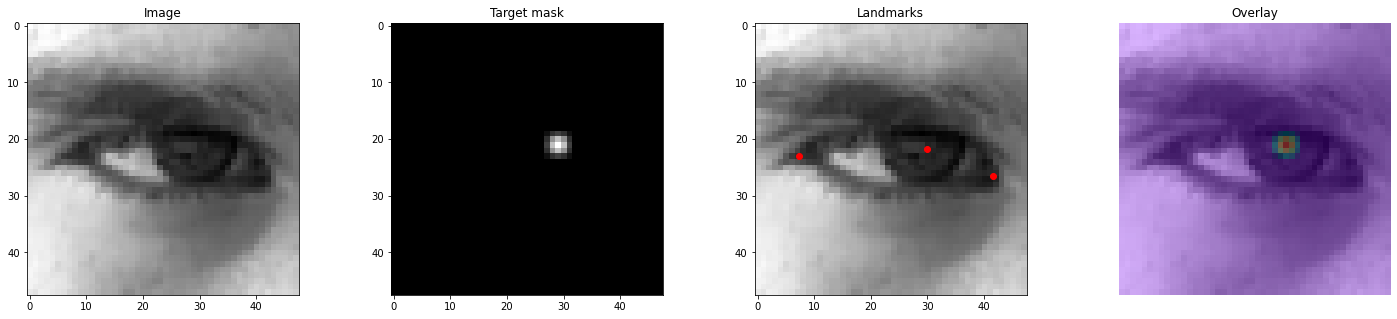

In [21]:
test_custom_dataset(iris_dataset, 3)

Now let's split the dataset into two parts of 80% and 20% (subtask 8).

In [22]:
train_size = int(0.8 * len(iris_dataset))
test_size = len(iris_dataset) - train_size

train_dataset, test_dataset = random_split(iris_dataset, [train_size, test_size])
print(f"The initial dataset was splitted into two parts of {len(train_dataset)} and {len(test_dataset)} records corresponding to {len(train_dataset) / len(iris_dataset) * 100:.02f}% and {len(test_dataset) / len(iris_dataset) * 100:.02f}% respectively.")

The initial dataset was splitted into two parts of 1977 and 495 records corresponding to 79.98% and 20.02% respectively.


### Step 2. Building CNN model.

The CNN model was built based on the architecture proposed by Jun Ho Choi et al. in ["Accurate Eye Pupil Localization Using Heterogeneous CNN Models"](https://ieeexplore.ieee.org/abstract/document/8803121). It has two losses: reconstruction loss for ensuring the model saves
important positional features and second loss which measures the distance between predicted eye center and ground truth one. The architecture also has skip connection which brings positional information to deep layer.

In [23]:
class IrisCA(Module):
    
    def __init__(self, activation=F.relu):
        super(IrisCA, self).__init__()
        self.activation = activation

        self.conv1 = Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1) 
        self.conv2 = Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=1)
        self.conv3 = Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)

        self.conv4 = Conv2d(in_channels=256, out_channels=64, kernel_size=3, padding=1)
        self.upsam1 = Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        
        self.conv5 = Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv6 = Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1)
        
        self.aux_conv1 = Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1) 
        self.aux_deconv1 = ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.aux_deconv2 = ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.aux_deconv3 = ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1)

        self.bn64 = BatchNorm2d(64)
        self.bn128 = BatchNorm2d(128)
        
    def forward(self, x):
        x = x.view(-1, 1, 48, 48)

        # encoder (base)
        x = self.activation(self.conv1(x))
        skip = torch.clone(x)
        x = self.bn64(x)
        x = self.activation(self.conv2(x))
        x = self.bn128(x)
        x = self.activation(self.conv3(x))
        
        # auxiliary network
        y = self.activation(self.aux_conv1(x))
        y = self.activation(self.aux_deconv1(y))
        y = self.activation(self.aux_deconv2(y))
        y = self.activation(self.aux_deconv3(y))

        # decoder (base)
        x = self.activation(self.conv4(x))
        x = self.upsam1(x)
        x = torch.cat((x, skip), dim=1)
        x = self.activation(self.conv5(x))
        x = self.conv6(x)
        return x, y

Let's check whether the architecture configured right and we can successfully perform image-to-image translation (the images can go through all the layers and eventually appear in the output).

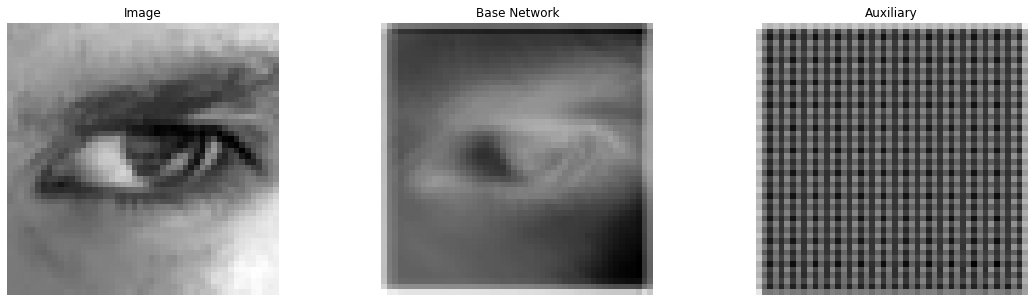

In [24]:
def check_architecture(model, data, idx):
    """
    Method used to check whether the image from dataset can be processed by the network.

    :param model: model to checked
    :param data: dataset
    :param idx: index of sample to be visualized
    """
    model.eval()
    sample = data[idx]
    image = sample['image']

    prediction, auxiliary = model(image)
    prediction, auxiliary = prediction.detach().numpy().reshape((48, 48)), auxiliary.detach().numpy().reshape((48, 48))    

    _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19,5))

    ax1.imshow(image, cmap='gray')
    ax1.title.set_text('Image')
    ax1.axis('off')
    ax2.imshow(prediction, cmap='gray')
    ax2.title.set_text('Base Network')
    ax2.axis('off')
    ax3.imshow(auxiliary, cmap='gray')
    ax3.title.set_text('Auxiliary')
    ax3.axis('off')
    plt.show()

model = IrisCA()
check_architecture(model, iris_dataset, 2)

## Step 3. Hyperparameters tuning.

Before proceeding with the hyperparameters tuning, it will be useful to define batch size, dataloaders, and auxiliary methods for training and testing. 

In [25]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=6)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
def train_model(model, optimizer, criterion, train_loader, n_epochs=5, logs=False, path=None, threshold=0.000060):
    """
    Method used to train model with given settings.

    :param model: model to be trained
    :param optimizer: optimizer
    :param criterion: loss function
    :param train_loader: train loader
    :param n_epochs: number of epochs
    :param logs: flag indicating whether training should be logged
    :param path: directory where to store checkpoints
    :return: trained model 
    """
    model.to(device)
    model.train()
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0

        for data in train_loader:
            image, mask = data['image'], data['mask']
            image, mask = image.to(device), mask.to(device)

            optimizer.zero_grad()
            prediction, restored = model(image)
            prediction = prediction.view(-1,48,48)
            restored = restored.view(-1,48,48)
            
            loss1 = criterion(prediction, mask)
            loss2 = criterion(restored, image)
            loss = loss1 + loss2

            train_loss += loss1.item() * image.size(0)

            loss.backward()
            optimizer.step()
            
        train_loss = train_loss/len(train_loader.dataset)

        if logs:
            print(f"Epoch: {epoch} \t Training Loss: {train_loss:.6f}")
        if path:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss, 
            }, os.path.join(path, f"{epoch}.pt"))
        
        if threshold and train_loss < threshold:
            break
    return model

In [28]:
def test_model(model, test_loader):
    """
    Method used to test model with given settings.
    As a performance metric there is used Dice coefficient:
    https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient

    :param model: model to be tested
    :param test_loader: test loader
    :return: dice score
    """
    model.eval()
    dice_score = 0.0

    with torch.no_grad():
        for data in test_loader:
            image, mask = data['image'], data['mask']
            image, mask = image.to(device), mask.to(device)

            prediction, _ = model(image)
            prediction = prediction.view(-1,48,48)
            dice_score += (2 * (prediction * mask).sum()) / (prediction + mask).sum() + 1e-8
    dice_score /= len(test_loader)
    return abs(float(dice_score))

In order to search for parameters, I implemented grid strategy that exhaustively going through the parameter space. As an performance metric for the model there was used [Dice coefficient](https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient) measuring the overlay of the target mask and the prediction.

In [29]:
def grid_search(Model, params, train_loader, test_loader):
    """
    Method used to perform Grid search for a given architecture.

    :param Model: model class 
    :param params: dictionary representing parameter space
    :param train_loader: train loader
    :param test_loader: test loader
    :return: dictionary with all model results and best parameters 
    """
    results = []
    combinations = list(itertools.product(params['optimizer'], params['loss'], params['activation']))
    n_epochs = params['n_epochs']
    for combination in combinations:
        optimizer_, loss_, activation_ = combination

        optimizer_name, Optimizer, lr = optimizer_
        loss_name, Loss = loss_
        activation_name, activation = activation_

        model = Model(activation)
        optimizer = Optimizer(model.parameters(), lr=lr)
        criterion = Loss()

        model = train_model(model, optimizer, criterion, train_loader, n_epochs=n_epochs, threshold=None)
        score = test_model(model, test_loader)

        entry = ([optimizer_name, loss_name, activation_name], score)
        results.append(entry)
    
    best_model = max(results, key=itemgetter(1))
    
    report = {
        'results': results, 
        'best_model': best_model
    }
    return report

In [30]:
params = {
    'optimizer': [('SGD', SGD, 0.001), ('Adam', Adam, 0.001), ('Adamax', Adamax, 0.002), ('RMSprop', RMSprop, 0.01)],
    'loss': [('MSELoss', MSELoss), ('L1Loss', L1Loss)],
    'activation': [('tanh', torch.tanh), ('relu', F.relu), ('sigmoid', torch.sigmoid)],
    'n_epochs': 10
}

report = grid_search(IrisCA, params, train_loader, test_loader)
best_model = report['best_model']
best_params = ", ".join(best_model[0])
print(f"The model trained with {best_params} gave highest Dice score of {best_model[1]:.02f}")

The model trained with Adam, MSELoss, relu gave highest Dice score of 0.42


## Step 4. Predictions for 10 images.

Once the best combination is found, let's create and train the final model.

In [43]:
model = IrisCA()
criterion = MSELoss()
optimizer = Adam(model.parameters())
model = train_model(model, optimizer, criterion, train_loader, n_epochs=200, logs=True)

Epoch: 1 	 Training Loss: 0.006523
Epoch: 2 	 Training Loss: 0.002042
Epoch: 3 	 Training Loss: 0.001838
Epoch: 4 	 Training Loss: 0.001610
Epoch: 5 	 Training Loss: 0.001456
Epoch: 6 	 Training Loss: 0.001338
Epoch: 7 	 Training Loss: 0.001253
Epoch: 8 	 Training Loss: 0.001174
Epoch: 9 	 Training Loss: 0.001099
Epoch: 10 	 Training Loss: 0.001012
Epoch: 11 	 Training Loss: 0.000894
Epoch: 12 	 Training Loss: 0.000803
Epoch: 13 	 Training Loss: 0.000750
Epoch: 14 	 Training Loss: 0.000704
Epoch: 15 	 Training Loss: 0.000647
Epoch: 16 	 Training Loss: 0.000607
Epoch: 17 	 Training Loss: 0.000578
Epoch: 18 	 Training Loss: 0.000529
Epoch: 19 	 Training Loss: 0.000494
Epoch: 20 	 Training Loss: 0.000477
Epoch: 21 	 Training Loss: 0.000541
Epoch: 22 	 Training Loss: 0.000476
Epoch: 23 	 Training Loss: 0.000451
Epoch: 24 	 Training Loss: 0.000437
Epoch: 25 	 Training Loss: 0.000487
Epoch: 26 	 Training Loss: 0.000403
Epoch: 27 	 Training Loss: 0.000351
Epoch: 28 	 Training Loss: 0.000322
E

In [44]:
score = test_model(model, test_loader)
print(f"Dice score for the model is {score}.")

Dice score for the model is 0.4342816472053528.


From the assignment statement:
> Draw predicted centers on them and visualize it. (You can draw iris center with cv2.circle())

Since the model performs image-to-image translation there is no need to draw iris centers. The output of my model is a segmentation mask with a round shape in the pupil location.

In [48]:
def plot_predictions(model, test_dataset, images_n):
    """
    Method used to plot predictions for the certain number of images from test dataset.

    :param model: trained model to create predictions
    :param test_dataset: test dataset
    :param images_n: number of images to be plotted
    """
    taken = []
    model.eval()
    for i in range(images_n):
        idx = randint(0, len(test_dataset))
        while idx in taken:
            idx = randint(0, len(test_dataset))

        sample = test_dataset[idx]

        image, mask = sample['image'], sample['mask']
        image = image.to(device)
        prediction, restored = model(image)

        image = image.cpu().data.numpy()
        prediction = prediction.cpu().data.numpy().reshape((48, 48)) 
        restored = restored.cpu().data.numpy().reshape((48, 48)) 

        _, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(17,5))

        ax1.imshow(image, cmap='gray')
        ax1.title.set_text('Original image')
        ax1.axis('off')
        ax2.imshow(restored, cmap='gray')
        ax2.title.set_text('Auxiliary network output')
        ax2.axis('off')
        ax3.imshow(mask, cmap='gray')
        ax3.title.set_text('Segmentation mask')
        ax3.axis('off')
        ax4.imshow(prediction, cmap='gray')   
        ax4.title.set_text('Base network output') 
        ax4.axis('off')
        plt.show()

        taken.append(idx)

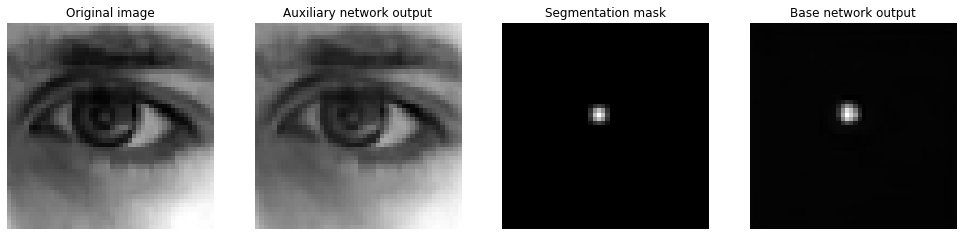

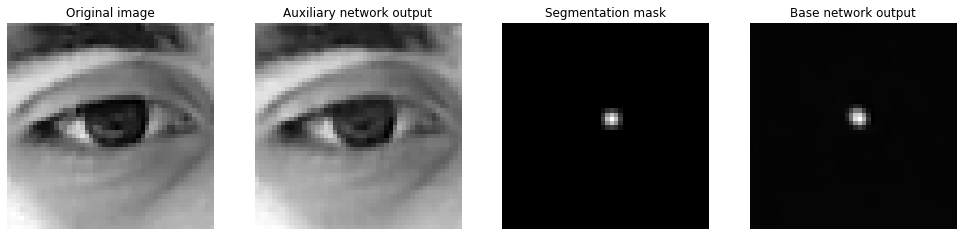

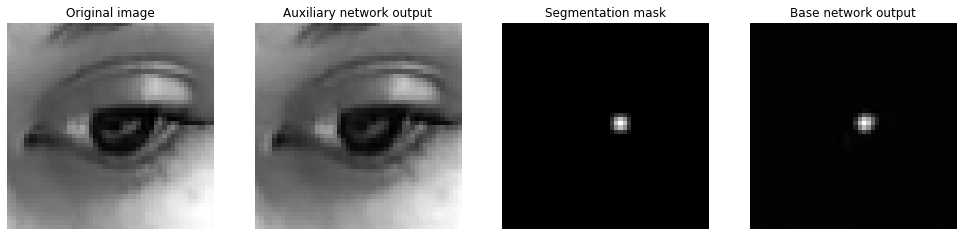

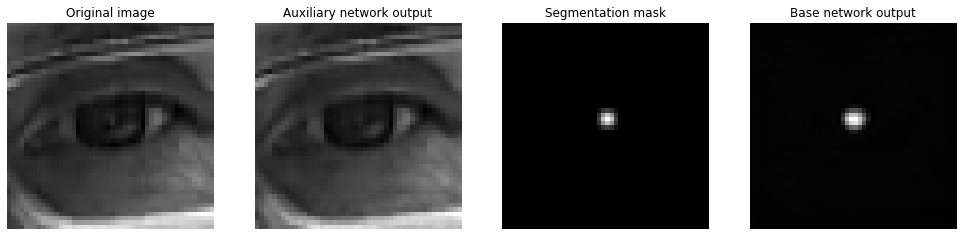

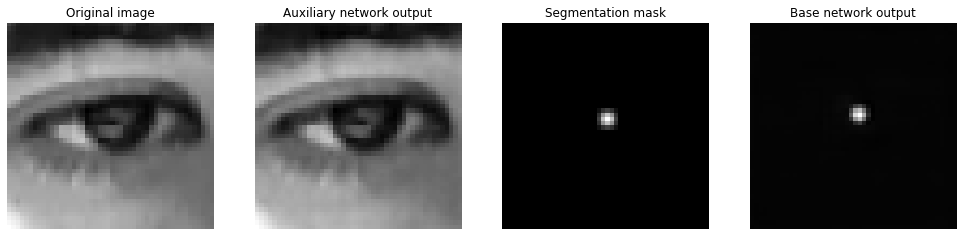

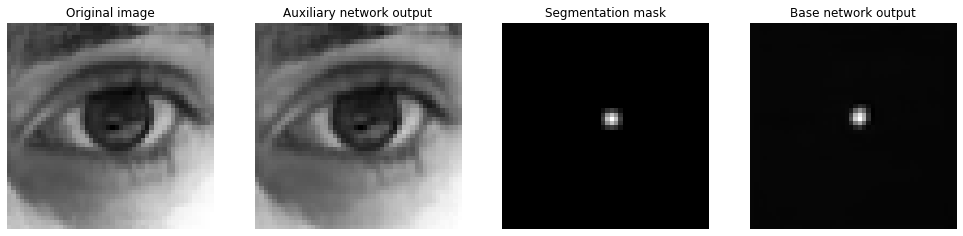

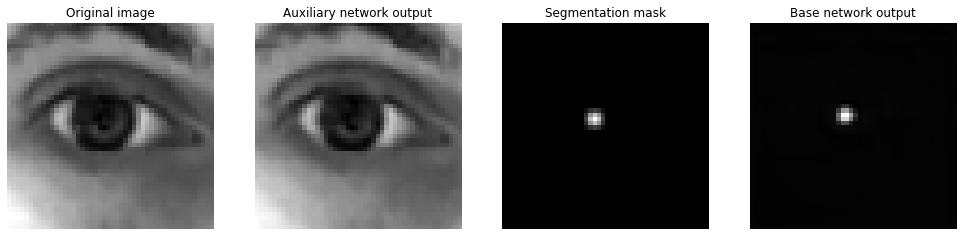

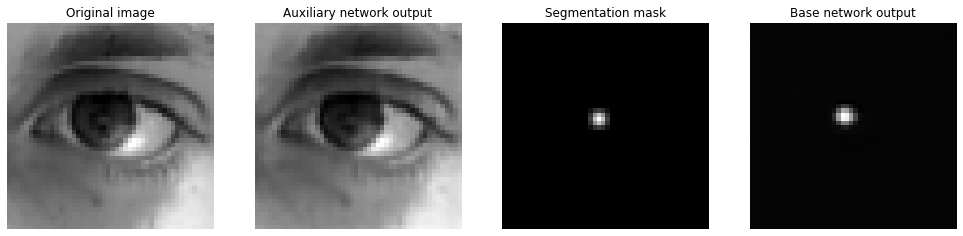

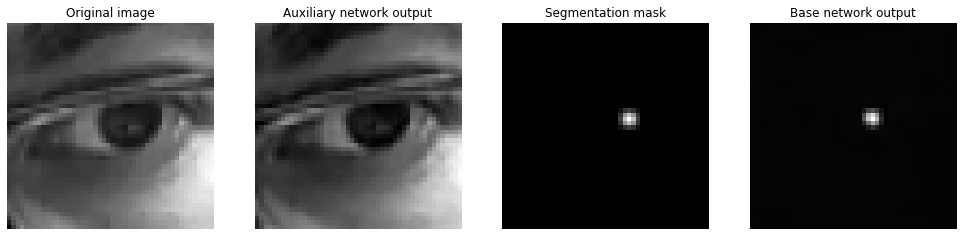

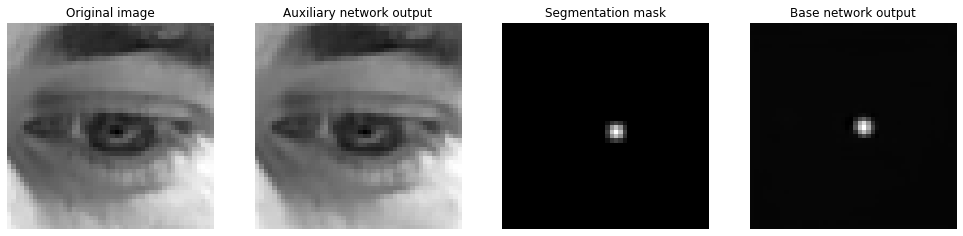

In [49]:
plot_predictions(model, test_dataset, 10)